In [3]:
import pandas as pd
import numpy as np

In [6]:
file_endings = "GSE89093"

In [98]:
train = pd.read_csv(f"../champ_result/GSE89093.csv")

In [ ]:
train_value = train.iloc[:, 1:]
train_value.head()

In [100]:
phe = pd.read_csv('../champ_result/GSE89093_phenotype.csv')
mask = phe['cancer_status'] == 'healthy'

In [101]:
train_normal = train_value.iloc[:,mask.values]
train_tumor = train_value.iloc[:,~mask.values]
train_normal = train_normal.T.reset_index(drop=True).T
train_tumor = train_tumor.T.reset_index(drop=True).T

In [ ]:
# train_normal
train_tumor

##### Calculate Δβ

In [103]:
# remove outlier based on every column
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR*1.5
    lower_fence = Q1 - IQR*1.5
    return upper_fence,lower_fence
def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf=df[(df>lower_fence)&(df<upper_fence)]
    return ddf

In [104]:
train_normal = no_outlier(train_normal)
train_tumor = no_outlier(train_tumor)

In [105]:
train_normal_avg = train_normal.mean(skipna=True, axis = 0)

In [106]:
train_tumor=(train_tumor).subtract(train_normal_avg, axis = 1)

In [107]:
train_tumor=no_outlier(train_tumor)

In [108]:
train_tumor_mean = train_tumor.mean(skipna=True, axis = 1)

In [ ]:
dbeta = pd.merge(train.iloc[:,:1], pd.DataFrame(train_tumor_mean, columns = ["dbeta"]), left_index=True, right_index=True)
dbeta

In [110]:
# rename ID_REF to ID
dbeta.rename(columns={"ID_REF": "ID"}, inplace=True)

In [ ]:
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.kdeplot(dbeta['dbeta'], label='healthy')
plt.xlabel('delta Beta value')
plt.title('Density plot of delta Beta value')

In [ ]:
GPL13534 = pd.read_csv("../external_result\GPL13534-11288.txt", sep="\t")

In [ ]:
GPL13534.columns

In [ ]:
GPL13534 = GPL13534[["ID", "UCSC_RefGene_Name", "UCSC_RefGene_Group"]]
GPL13534.dropna(inplace=True)
GPL13534

In [ ]:
result = pd.merge(dbeta, GPL13534, on="ID", how="inner")
result

In [ ]:
result['UCSC_RefGene_Name'] = result['UCSC_RefGene_Name'].str.split(';').str[0]
result['UCSC_RefGene_Group'] = result['UCSC_RefGene_Group'].str.split(';').str[0]
result

In [ ]:
def find_max_dBeta_grouped(group):
    idx_max = group['dbeta'].abs().idxmax()
    return group.loc[idx_max]

result_max_per_gene = result.groupby("UCSC_RefGene_Name").apply(find_max_dBeta_grouped).reset_index(drop=True)

In [118]:
single = pd.read_csv('../comorbidity/matchgene174_single_3Y10__OR2.txt', sep='\t', header=None)

In [ ]:
result_max_per_gene_single = result_max_per_gene[result_max_per_gene['UCSC_RefGene_Name'].isin(single[0])]
result_max_per_gene_single

In [120]:
file_endings

'GSE89093'

In [122]:
result_max_per_gene_single.to_csv(f"../result/result_basic_dbeta_{file_endings}.csv", index=False)

Lazy reading, skip when exectuing the code from top to bottom.

In [7]:
result_basic_dbeta = pd.read_csv(f"../result/result_basic_dbeta_{file_endings}.csv")

In [ ]:
dbeta_process_liquid = result_basic_dbeta.copy()
dbeta_process_liquid

Filter by TSS1500 & TSS200 (Optional)

In [ ]:
# remove rows that UCSC_RefGene_Group != 'TSS200' or 'TSS1500'
dbeta_process_liquid = dbeta_process_liquid[dbeta_process_liquid['UCSC_RefGene_Group'].isin(['TSS200', 'TSS1500'])]
dbeta_process_liquid

In [9]:
result_max_per_gene_single = pd.read_csv(f"../result/result_basic_process.csv")

In [ ]:
dbeta_process_tissue = result_max_per_gene_single.copy()
dbeta_process_tissue.columns = ['ID', 'dbeta', 'UCSC_RefGene_Name']
dbeta_process_tissue

In [ ]:
# intersect between liquid and tissue
interseted = pd.merge(dbeta_process_liquid, dbeta_process_tissue, on="ID", how="inner")
interseted = interseted[(interseted['dbeta_x'] * interseted['dbeta_y']) > 0]
interseted = interseted.drop(columns=['UCSC_RefGene_Name_y'])
interseted = interseted.rename(columns={'UCSC_RefGene_Name_x': 'UCSC_RefGene_Name'})
interseted = interseted.rename(columns={'dbeta_x': 'dbeta_liquid'})
interseted = interseted.rename(columns={'dbeta_y': 'dbeta_tissue'})
interseted = interseted[['ID', 'UCSC_RefGene_Name', 'dbeta_liquid', 'dbeta_tissue']]
print(interseted.shape)
interseted

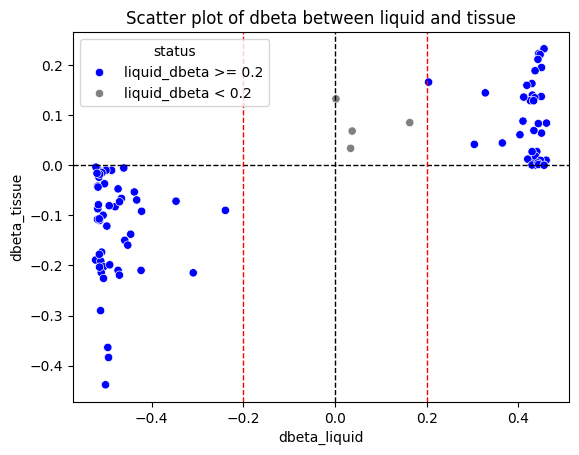

In [12]:
# draw scatter plot for liquid and tissue
import matplotlib.pyplot as plt
import seaborn as sns
interseted['status'] = np.where(abs(interseted['dbeta_liquid']) < 0.2, 'liquid_dbeta < 0.2', 'liquid_dbeta >= 0.2')

sns.scatterplot(
    data=interseted,
    x='dbeta_liquid',
    y='dbeta_tissue',
    hue='status',
    palette=['blue', 'gray'])
plt.xlabel('dbeta_liquid')
plt.ylabel('dbeta_tissue')
plt.title('Scatter plot of dbeta between liquid and tissue')
plt.axhline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.axvline(0.2, color='red', linewidth=1, linestyle='--')
plt.axvline(-0.2, color='red', linewidth=1, linestyle='--')
plt.show()

In [ ]:
interseted = interseted[abs(interseted['dbeta_liquid']) >= 0.2]
interseted = interseted.drop(columns=['status'])
print(interseted.shape)
interseted

In [14]:
interseted.to_csv(f"../result/train_and_GSE89093_interseted.csv", index=False)